In [1]:
import pandas as pd


df = pd.read_csv('GlobalLandTemperaturesByMajorCity.csv', parse_dates=['dt'])
df = df[df['dt'].dt.year >= 1950]  


print(df.isnull().sum())

dt                                0
AverageTemperature               93
AverageTemperatureUncertainty    93
City                              0
Country                           0
Latitude                          0
Longitude                         0
dtype: int64


# Getting the best cities with each cluster through the use of k-means 

In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans



cities = df.groupby('City').agg({
    'Country': 'first',
    'Latitude': 'first',
    'Longitude': 'first',
    'AverageTemperature': 'count'  
}).reset_index()
cities.rename(columns={'AverageTemperature': 'DataPoints'}, inplace=True)

#ONLY CITIES WITH <80 completeness
min_data_points = len(df['dt'].unique()) * 0.8
qualified_cities = cities[cities['DataPoints'] >= min_data_points].copy()


#converter coord to floats
def coord_to_float(coord):
    if isinstance(coord, str):
        try:
            value = float(coord[:-1])
            direction = coord[-1].upper()
            if direction in ['W', 'S']:
                return -value
            return value
        except:
            return np.nan
    return coord


qualified_cities['Latitude'] = qualified_cities['Latitude'].apply(coord_to_float)
qualified_cities['Longitude'] = qualified_cities['Longitude'].apply(coord_to_float)

#DROP BS LAT OR LONG 
qualified_cities = qualified_cities.dropna(subset=['Latitude', 'Longitude'])



def lat_to_float(x):
    if isinstance(x, str):
        return float(x[:-1]) * (1 if x[-1] == 'N' else -1)
    return x
qualified_cities['Latitude'] = qualified_cities['Latitude'].apply(lat_to_float)


kmeans = KMeans(n_clusters=30, random_state=42)  

qualified_cities['Longitude'] = qualified_cities['Longitude'].apply(coord_to_float)


print(qualified_cities[['City', 'Latitude', 'Longitude']].head())

#KMEANS
kmeans = KMeans(n_clusters=30, random_state=42)
qualified_cities['Cluster'] = kmeans.fit_predict(qualified_cities[['Latitude', 'Longitude']])



selected_cities = qualified_cities.loc[
    qualified_cities.groupby('Cluster')['DataPoints'].idxmax()
]


print(f"Selected {len(selected_cities)} cities:")
print(selected_cities[['City', 'Country', 'Latitude', 'Longitude']].sort_values('Latitude'))


df_selected = df[df['City'].isin(selected_cities['City'])]
print(f"\nFiltered dataset shape: {df_selected.shape}")

selected_cities.to_csv('selected_cities.csv', index=False)
df_selected.to_csv('filtered_temperatures.csv', index=False)

df = df[df['City'].isin(selected_cities['City'])]

          City  Latitude  Longitude
0      Abidjan      5.63      -3.23
1  Addis Abeba      8.84      38.11
2    Ahmadabad     23.31      72.52
3       Aleppo     36.17      37.79
4   Alexandria     31.35      30.16
Selected 30 cities:
              City                             Country  Latitude  Longitude
61       Melbourne                           Australia    -37.78     144.41
81        Santiago                               Chile    -32.95     -69.89
17       Cape Town                        South Africa    -32.95      18.19
9   Belo Horizonte                              Brazil    -20.09     -44.36
25   Dar Es Salaam                            Tanzania     -7.23      39.73
41         Jakarta                           Indonesia     -5.63     106.55
30       Fortaleza                              Brazil     -4.02     -40.98
49        Kinshasa  Congo (Democratic Republic Of The)     -4.02      15.27
11          Bogotá                            Colombia      4.02     -74.73
0   

# Missing data with the use of KNN respects local similarities

In [3]:
from sklearn.impute import KNNImputer

#MISSING KNN DATA INFIL 

pivot = df.pivot_table(index=['dt', 'City'], 
                      values=['AverageTemperature', 'AverageTemperatureUncertainty'])


imputer = KNNImputer(n_neighbors=5)
imputed_values = imputer.fit_transform(pivot)


df_imputed = (
    pd.DataFrame(imputed_values, 
                columns=pivot.columns, 
                index=pivot.index)
    .reset_index()
)

#Merge
other_cols = df.columns.difference(['AverageTemperature', 'AverageTemperatureUncertainty'])
df_imputed = df_imputed.merge(
    df[other_cols].drop_duplicates(['dt', 'City']),
    on=['dt', 'City'],
    how='left'
)


print(df_imputed.head())

          dt         City  AverageTemperature  AverageTemperatureUncertainty  \
0 1950-01-01      Abidjan              26.773                          0.239   
1 1950-01-01  Addis Abeba              17.031                          0.303   
2 1950-01-01    Ahmadabad              19.938                          0.181   
3 1950-01-01       Aleppo               1.086                          0.833   
4 1950-01-01      Baghdad               5.982                          0.368   

         Country Latitude Longitude  
0  Côte D'Ivoire    5.63N     3.23W  
1       Ethiopia    8.84N    38.11E  
2          India   23.31N    72.52E  
3          Syria   36.17N    37.79E  
4           Iraq   32.95N    45.00E  


In [4]:
print(df_imputed.isnull().sum())

dt                               0
City                             0
AverageTemperature               0
AverageTemperatureUncertainty    0
Country                          0
Latitude                         0
Longitude                        0
dtype: int64


In [5]:
print(df_imputed.head())

          dt         City  AverageTemperature  AverageTemperatureUncertainty  \
0 1950-01-01      Abidjan              26.773                          0.239   
1 1950-01-01  Addis Abeba              17.031                          0.303   
2 1950-01-01    Ahmadabad              19.938                          0.181   
3 1950-01-01       Aleppo               1.086                          0.833   
4 1950-01-01      Baghdad               5.982                          0.368   

         Country Latitude Longitude  
0  Côte D'Ivoire    5.63N     3.23W  
1       Ethiopia    8.84N    38.11E  
2          India   23.31N    72.52E  
3          Syria   36.17N    37.79E  
4           Iraq   32.95N    45.00E  


In [6]:
df_imputed = df_imputed.round({
    'AverageTemperature': 1,       
    'AverageTemperatureUncertainty': 1,
})


# QUICK DATA VISIUALIZATION 

Total unique cities in dataset: 3,448

Cities per country (Top 20):
Country
India             391
China             371
United States     248
Brazil            220
Japan             175
Russia            156
Indonesia         143
Mexico             97
Nigeria            91
Germany            81
United Kingdom     68
Iran               66
Philippines        65
Pakistan           59
Turkey             51
South Africa       50
Spain              50
Italy              42
Venezuela          40
Colombia           39
Name: City, dtype: int64


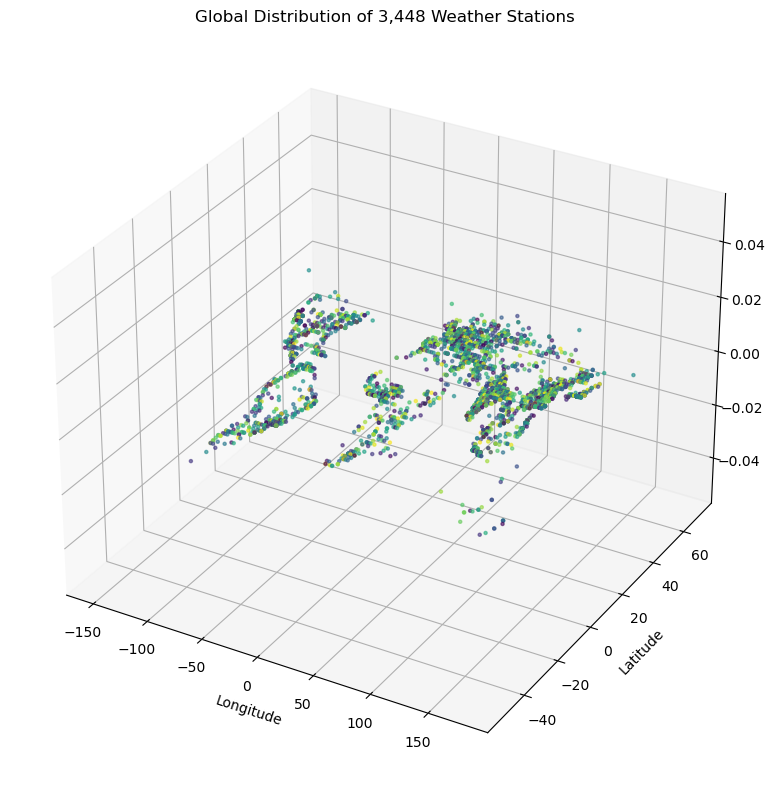


Additional Stats:
- Cities in Northern Hemisphere: 2,840
- Cities in Southern Hemisphere: 608
- Coastal cities (estimated): 182


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('GlobalLandTemperaturesByCity.csv')


unique_cities = df['City'].nunique()
print(f"Total unique cities in dataset: {unique_cities:,}")


cities_per_country = df.groupby('Country')['City'].nunique().sort_values(ascending=False)
print("\nCities per country (Top 20):")
print(cities_per_country.head(20))


def convert_coord(coord):
    if isinstance(coord, str):
        value = float(coord[:-1])
        return -value if coord[-1] in ['W', 'S'] else value
    return coord

coord_df = df.groupby('City').first()[['Latitude', 'Longitude']].applymap(convert_coord)


plt.figure(figsize=(15, 8))


ax = plt.subplot(111, projection='3d')
ax.scatter(
    coord_df['Longitude'],
    coord_df['Latitude'],
    c=coord_df.index.map(hash) % 100,  
    s=5,
    alpha=0.6
)

ax.set(
    xlabel='Longitude',
    ylabel='Latitude',
    title=f'Global Distribution of {unique_cities:,} Weather Stations'
)
plt.tight_layout()
plt.savefig('city_distribution.png', dpi=300)
plt.show()


full_city_list = df[['City', 'Country', 'Latitude', 'Longitude']].drop_duplicates()
full_city_list.to_csv('all_cities_list.csv', index=False)

print("\nAdditional Stats:")
print(f"- Cities in Northern Hemisphere: {(coord_df['Latitude'] > 0).sum():,}")
print(f"- Cities in Southern Hemisphere: {(coord_df['Latitude'] < 0).sum():,}")
print(f"- Coastal cities (estimated): {(abs(coord_df['Longitude']) < 5).sum():,}")

In [8]:
uuunique_cities = df_imputed['City'].nunique()
print(f"Total unique cities in dataset: {uuunique_cities:,}")

Total unique cities in dataset: 30


In [9]:
print(df['City'].nunique())

3448


In [10]:
df_selected = df_imputed[df_imputed['City'].isin(selected_cities['City'])]

In [11]:


unique_cities = df_imputed['City'].nunique()
print(f"Total unique cities in dataset: {unique_cities:,}")

Total unique cities in dataset: 30


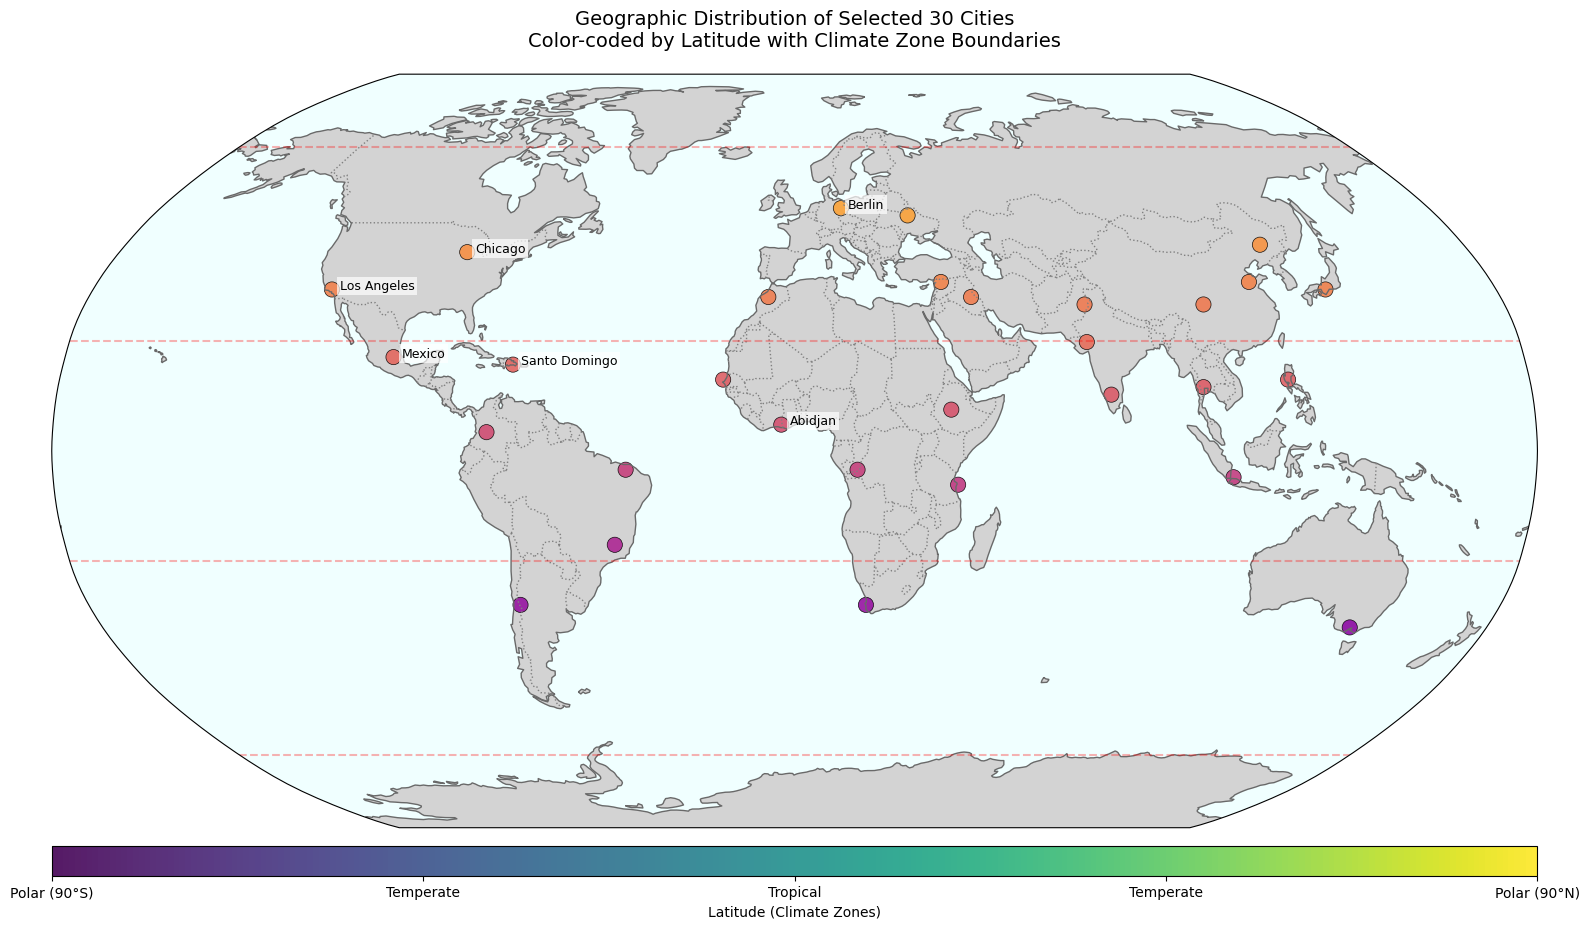

In [12]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import numpy as np


selected_cities = pd.read_csv('selected_cities.csv')  


plt.figure(figsize=(16, 10))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='azure')
ax.add_feature(cfeature.COASTLINE, edgecolor='dimgray')
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray')


colors = plt.cm.plasma((selected_cities['Latitude'] + 90) / 180)  
scatter = ax.scatter(
    selected_cities['Longitude'],
    selected_cities['Latitude'],
    c=colors,
    s=120,
    transform=ccrs.PlateCarree(),
    edgecolors='black',
    linewidths=0.5,
    alpha=0.9
)


label_cities = pd.concat([
    selected_cities.nlargest(5, 'DataPoints'),
    selected_cities.loc[[selected_cities['Latitude'].abs().idxmax()]]  
])

for _, row in label_cities.iterrows():
    ax.text(
        row['Longitude'] + 2,
        row['Latitude'],
        row['City'],
        transform=ccrs.PlateCarree(),
        fontsize=9,
        ha='left',
        bbox=dict(facecolor='white', alpha=0.7, pad=2, edgecolor='none')
    )

#CLIMATE zones 
for lat in [-66.5, -23.5, 23.5, 66.5]:
    ax.plot([-180, 180], [lat, lat], 
            color='red', 
            linestyle='--', 
            alpha=0.3, 
            transform=ccrs.PlateCarree())


cbar = plt.colorbar(scatter, orientation='horizontal', pad=0.02, aspect=50)
cbar.set_label('Latitude (Climate Zones)')
cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])
cbar.set_ticklabels(['Polar (90°S)', 'Temperate', 'Tropical', 'Temperate', 'Polar (90°N)'])


plt.title('Geographic Distribution of Selected 30 Cities\n'
         'Color-coded by Latitude with Climate Zone Boundaries',
         pad=20, fontsize=14)
plt.tight_layout()

# Save high-res version

plt.show()

In [13]:
print(df_selected.head())

          dt         City  AverageTemperature  AverageTemperatureUncertainty  \
0 1950-01-01      Abidjan                26.8                            0.2   
1 1950-01-01  Addis Abeba                17.0                            0.3   
2 1950-01-01    Ahmadabad                19.9                            0.2   
3 1950-01-01       Aleppo                 1.1                            0.8   
4 1950-01-01      Baghdad                 6.0                            0.4   

         Country Latitude Longitude  
0  Côte D'Ivoire    5.63N     3.23W  
1       Ethiopia    8.84N    38.11E  
2          India   23.31N    72.52E  
3          Syria   36.17N    37.79E  
4           Iraq   32.95N    45.00E  


In [14]:

# df_imputed = df_imputed.sort_values('dt')


# split_idx = int(len(df_imputed) * 0.8)
# train = df_imputed.iloc[:split_idx]
# test = df_imputed.iloc[split_idx:]

# print(f"Train: {train['dt'].min().date()} to {train['dt'].max().date()}") 
# print(f"Test: {test['dt'].min().date()} to {test['dt'].max().date()}")
# print(f"Train %: {len(train)/len(df_selected):.1%}, Test %: {len(test)/len(df_imputed):.1%}")

# CONVERTING THE COORDS TO FLOATS, N/S/E/W -> FLOATS, CYCLIC ENCODING 

In [15]:
def convert_coordinate(coord):
    if isinstance(coord, str):
        direction = coord[-1].upper()  
        value = float(coord[:-1])      
        if direction in ['S', 'W']:
            value *= -1  
        return value
    return coord  


df_imputed['Latitude'] = df_imputed['Latitude'].apply(convert_coordinate)
df_imputed['Longitude'] = df_imputed['Longitude'].apply(convert_coordinate)

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score


df_imputed['dt'] = pd.to_datetime(df_imputed['dt'])


df_imputed['year'] = df_imputed['dt'].dt.year
df_imputed['month'] = df_imputed['dt'].dt.month
df_imputed['day_of_year'] = df_imputed['dt'].dt.dayofyear


df_imputed['month_sin'] = np.sin(2 * np.pi * df_imputed['month'] / 12)
df_imputed['month_cos'] = np.cos(2 * np.pi * df_imputed['month'] / 12)


city_dummies = pd.get_dummies(df_imputed['City'], prefix='city')
df_imputed = pd.concat([df_imputed, city_dummies], axis=1)


city_dummy_cols = [col for col in df_imputed.columns if col.startswith('city_')]


df_imputed = df_imputed.drop(columns=city_dummy_cols)


print("Columns after removing one-hot cities:", df_imputed.columns)


# WITHOUT THE CO2 
# feature_cols = ['Latitude', 'Longitude', 'year', 'month_sin', 'month_cos'] + \
#                [col for col in df_imputed.columns if col.startswith('city_')]
# X = df_imputed[feature_cols]
# y = df_imputed['AverageTemperature']


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Columns after removing one-hot cities: Index(['dt', 'City', 'AverageTemperature', 'AverageTemperatureUncertainty',
       'Country', 'Latitude', 'Longitude', 'year', 'month', 'day_of_year',
       'month_sin', 'month_cos'],
      dtype='object')


In [17]:
print(df_imputed)

              dt           City  AverageTemperature  \
0     1950-01-01        Abidjan                26.8   
1     1950-01-01    Addis Abeba                17.0   
2     1950-01-01      Ahmadabad                19.9   
3     1950-01-01         Aleppo                 1.1   
4     1950-01-01        Baghdad                 6.0   
...          ...            ...                 ...   
22919 2013-08-01  Santo Domingo                28.4   
22920 2013-09-01        Chicago                20.0   
22921 2013-09-01    Los Angeles                23.3   
22922 2013-09-01         Mexico                18.3   
22923 2013-09-01  Santo Domingo                28.3   

       AverageTemperatureUncertainty             Country  Latitude  Longitude  \
0                                0.2       Côte D'Ivoire      5.63      -3.23   
1                                0.3            Ethiopia      8.84      38.11   
2                                0.2               India     23.31      72.52   
3              

In [18]:
df_emissions = pd.read_csv('owid-co2-data.csv')
df_emissions = df_emissions[df_emissions['year'] >= 1950]  # Adjust column name if needed


# COMBINING THE TWO DATASET AS COUNTRY IS OUR JOINT

In [19]:
valid_countries = df_imputed['Country'].unique() 
df_emissions_filtered = df_emissions[df_emissions['country'].isin(valid_countries)]

In [20]:
print(valid_countries)
df_emissions_filtered.head()

["Côte D'Ivoire" 'Ethiopia' 'India' 'Syria' 'Iraq' 'Thailand' 'Brazil'
 'Germany' 'Colombia' 'South Africa' 'Morocco' 'China' 'United States'
 'Senegal' 'Tanzania' 'Pakistan' 'Indonesia' 'Ukraine'
 'Congo (Democratic Republic Of The)' 'Philippines' 'Australia' 'Mexico'
 'Japan' 'Chile' 'Dominican Republic']


,country,year,iso_code,population,gdp,cement_co2,cement_co2_per_capita,co2,co2_growth_abs,co2_growth_prct,...,share_global_other_co2,share_of_temperature_change_from_ghg,temperature_change_from_ch4,temperature_change_from_co2,temperature_change_from_ghg,temperature_change_from_n2o,total_ghg,total_ghg_excluding_lucf,trade_co2,trade_co2_share
3588,Australia,1950,AUS,8176751.0,9.767859e+10,0.632,0.077,55.738,7.674,15.966,...,NaN,1.776,0.003,0.003,0.007,0.001,260.164,76.096,NaN,NaN
3589,Australia,1951,AUS,8418614.0,1.018378e+11,0.611,0.073,61.122,5.384,9.659,...,NaN,1.778,0.003,0.004,0.007,0.001,279.058,82.490,NaN,NaN
3590,Australia,1952,AUS,8630704.0,1.027649e+11,0.672,0.078,62.447,1.325,2.167,...,NaN,1.781,0.003,0.004,0.008,0.001,294.433,84.436,NaN,NaN
3591,Australia,1953,AUS,8816084.0,1.059673e+11,0.789,0.089,63.036,0.589,0.944,...,NaN,1.784,0.003,0.004,0.008,0.001,299.875,85.594,NaN,NaN
3592,Australia,1954,AUS,8999382.0,1.125660e+11,0.945,0.105,67.943,4.907,7.784,...,NaN,1.788,0.003,0.004,0.008,0.001,313.091,91.838,NaN,NaN


In [21]:
print("Columns in emissions dataset:", df_emissions.columns.tolist())



Columns in emissions dataset: ['country', 'year', 'iso_code', 'population', 'gdp', 'cement_co2', 'cement_co2_per_capita', 'co2', 'co2_growth_abs', 'co2_growth_prct', 'co2_including_luc', 'co2_including_luc_growth_abs', 'co2_including_luc_growth_prct', 'co2_including_luc_per_capita', 'co2_including_luc_per_gdp', 'co2_including_luc_per_unit_energy', 'co2_per_capita', 'co2_per_gdp', 'co2_per_unit_energy', 'coal_co2', 'coal_co2_per_capita', 'consumption_co2', 'consumption_co2_per_capita', 'consumption_co2_per_gdp', 'cumulative_cement_co2', 'cumulative_co2', 'cumulative_co2_including_luc', 'cumulative_coal_co2', 'cumulative_flaring_co2', 'cumulative_gas_co2', 'cumulative_luc_co2', 'cumulative_oil_co2', 'cumulative_other_co2', 'energy_per_capita', 'energy_per_gdp', 'flaring_co2', 'flaring_co2_per_capita', 'gas_co2', 'gas_co2_per_capita', 'ghg_excluding_lucf_per_capita', 'ghg_per_capita', 'land_use_change_co2', 'land_use_change_co2_per_capita', 'methane', 'methane_per_capita', 'nitrous_oxide'

In [22]:
emission_feat = ['co2', 'co2_per_capita', 'coal_co2', 'country', 'year']
df_emissions_filtered = df_emissions[emission_feat].copy()  

In [23]:
df_emissions_filtered.head()

,co2,co2_per_capita,coal_co2,country,year
200,0.084,0.011,0.021,Afghanistan,1950
201,0.092,0.012,0.026,Afghanistan,1951
202,0.092,0.011,0.032,Afghanistan,1952
203,0.106,0.013,0.038,Afghanistan,1953
204,0.106,0.013,0.043,Afghanistan,1954


In [24]:

df_emissions_filtered = df_emissions_filtered.rename(columns={'country': 'Country'})
df_emissions_filtered = df_emissions_filtered.rename(columns={'year': 'Year'})

df_imputed['Year'] = pd.to_datetime(df_imputed['dt']).dt.year


df_combined = pd.merge(
    df_imputed,               
    df_emissions_filtered,    
    on=['Country', 'Year'],   
    how='left'                
)

In [25]:

df_combined['co2'] = df_combined.groupby('Country')['co2'].transform(
    lambda x: x.fillna(x.median())
)

In [26]:
print("Duplicate rows:", df_combined.duplicated().sum())

Duplicate rows: 0


# FILLING MISSING DATA OF THE CO2 DATASET

In [27]:
for col in ['co2', 'co2_per_capita', 'coal_co2']:

    country_medians = df_combined.groupby('Country')[col].median()
    

    df_combined[col] = df_combined[col].fillna(
        df_combined['Country'].map(country_medians)
    )
    

    global_median = df_combined[col].median()
    df_combined[col] = df_combined[col].fillna(global_median)
    
print("Missing values after imputation:")
print(df_combined[['co2', 'co2_per_capita', 'coal_co2']].isnull().sum())

df_combined = df_combined.drop(columns=['Year'], errors='ignore')  

Missing values after imputation:
co2               0
co2_per_capita    0
coal_co2          0
dtype: int64


# SPLITTING THE DATA INTO TRAINING AND VALIDATION SET 70-30 SPLIT 

In [28]:
from sklearn.model_selection import train_test_split


feature_cols = [
    'Latitude', 'Longitude', 'year', 'month_sin', 'month_cos',
    'co2', 'co2_per_capita', 'coal_co2'  # Emission features
]


target_col = 'AverageTemperature'

X = df_combined[feature_cols]
y = df_combined[target_col]


X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.3,
    random_state=42,  
    shuffle=True,

)


print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print("\nFeature columns:", X_train.columns.tolist())

Training set: 16046 samples
Test set: 6878 samples

Feature columns: ['Latitude', 'Longitude', 'year', 'month_sin', 'month_cos', 'co2', 'co2_per_capita', 'coal_co2']


In [29]:

# lr = LinearRegression()
# lr.fit(X_train, y_train)  # Make sure this runs without errors


# print("Coefficients:", lr.coef_)
# print("Intercept:", lr.intercept_)

In [30]:
# print("NaN values in X_train:", X_train.isnull().sum().sum())
# print("NaN values in y_train:", y_train.isnull().sum())

In [31]:
# from sklearn.impute import SimpleImputer
# from sklearn.pipeline import make_pipeline


# pipe = make_pipeline(
#     SimpleImputer(strategy='median'),  # Handles any remaining NaNs
#     LinearRegression()
# )

# pipe.fit(X_train, y_train)


# final_model = pipe.named_steps['linearregression']
# print("Coefficients:", final_model.coef_)
# print("Intercept:", final_model.intercept_)

# TESTING THE MODELS PERFORMANCES OF ALL FOUR, BASLEINE LINEAR REGRESSION, RF, NN AND XGBOOST

In [32]:
#BASELINE MODEL 
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

lr = LinearRegression()
lr.fit(X_train, y_train)

pipe = make_pipeline(
    SimpleImputer(strategy='median'),  # Handles any remaining NaNs
    LinearRegression()
)

pipe.fit(X_train, y_train)

# Train/evaluate
y_pred = pipe.predict(X_test)

# Evaluate
y_pred = lr.predict(X_test)
print(f"Linear Regression:")
print(f"  MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"  R²: {r2_score(y_test, y_pred):.2f}")

# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import RandomizedSearchCV

# # Train

# rf_optimized = RandomForestRegressor(
#     n_estimators=300,
#     min_samples_split=10,
#     min_samples_leaf=2,
#     max_features='log2',
#     max_depth=None,  # No limit on tree depth
#     random_state=42,
#     n_jobs=-1  # Use all CPU cores
# )


# rf_optimized.fit(X_train, y_train)


# y_pred_rf = rf_optimized.predict(X_test)


# rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
# r2_rf = r2_score(y_test, y_pred_rf)

# print("Optimized Random Forest Results:")
# print(f"- RMSE: {rmse_rf:.4f}")
# print(f"- R²: {r2_rf:.4f}")

from xgboost import XGBRegressor

X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)

xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    early_stopping_rounds=50,
    eval_metric=['rmse', 'mae'],
    random_state=42
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)


y_pred = xgb_model.predict(X_test)
xgb_r2 = r2_score(y_test, y_pred)
print(f"\nXGBoost Test R²: {xgb_r2:.4f}")


results = xgb_model.evals_result()
print(f"Final Validation RMSE: {results['validation_0']['rmse'][-1]:.4f}")
print(f"Final Validation MAE: {results['validation_0']['mae'][-1]:.4f}")

Linear Regression:
  MAE: 5.49
  R²: 0.36
[0]	validation_0-rmse:6.60385	validation_0-mae:5.21853
[1]	validation_0-rmse:4.92639	validation_0-mae:3.87388
[2]	validation_0-rmse:3.78576	validation_0-mae:2.96730
[3]	validation_0-rmse:3.08323	validation_0-mae:2.39697
[4]	validation_0-rmse:2.54857	validation_0-mae:1.95868
[5]	validation_0-rmse:2.15103	validation_0-mae:1.63348
[6]	validation_0-rmse:1.93845	validation_0-mae:1.46052
[7]	validation_0-rmse:1.73750	validation_0-mae:1.29288
[8]	validation_0-rmse:1.61051	validation_0-mae:1.19222
[9]	validation_0-rmse:1.54199	validation_0-mae:1.14260
[10]	validation_0-rmse:1.43470	validation_0-mae:1.06196
[11]	validation_0-rmse:1.37913	validation_0-mae:1.01807
[12]	validation_0-rmse:1.34461	validation_0-mae:0.98337
[13]	validation_0-rmse:1.31662	validation_0-mae:0.96272
[14]	validation_0-rmse:1.29072	validation_0-mae:0.93841
[15]	validation_0-rmse:1.26065	validation_0-mae:0.91226
[16]	validation_0-rmse:1.24529	validation_0-mae:0.89817
[17]	validation_

In [33]:
print("Missing values in X_train:")
print(X_train.isnull().sum())

print("\nMissing values in X_test:")
print(X_test.isnull().sum())

Missing values in X_train:
Latitude          0
Longitude         0
year              0
month_sin         0
month_cos         0
co2               0
co2_per_capita    0
coal_co2          0
dtype: int64

Missing values in X_test:
Latitude          0
Longitude         0
year              0
month_sin         0
month_cos         0
co2               0
co2_per_capita    0
coal_co2          0
dtype: int64



Optimized Random Forest Results:
- MAE:  0.7856
- RMSE: 1.1525
- R²:   0.9837


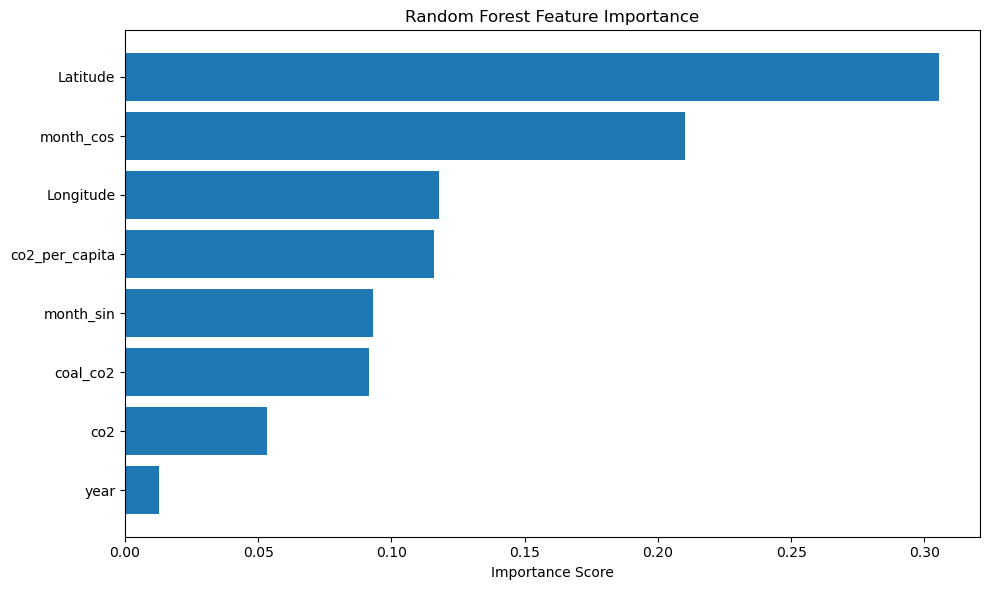

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


rf_optimized = RandomForestRegressor(
    n_estimators=300,
    min_samples_split=10,
    min_samples_leaf=2,
    max_features='log2',
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_optimized.fit(X_train, y_train)


y_pred_rf = rf_optimized.predict(X_test)


mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)


print("\nOptimized Random Forest Results:")
print(f"- MAE:  {mae_rf:.4f}")  
print(f"- RMSE: {rmse_rf:.4f}")
print(f"- R²:   {r2_rf:.4f}")


import matplotlib.pyplot as plt
importances = rf_optimized.feature_importances_
features = X_train.columns 
sorted_idx = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), features[sorted_idx])
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


=== Final Metrics ===
R²: 0.9836
RMSE: 1.1561
MAE: 0.8246


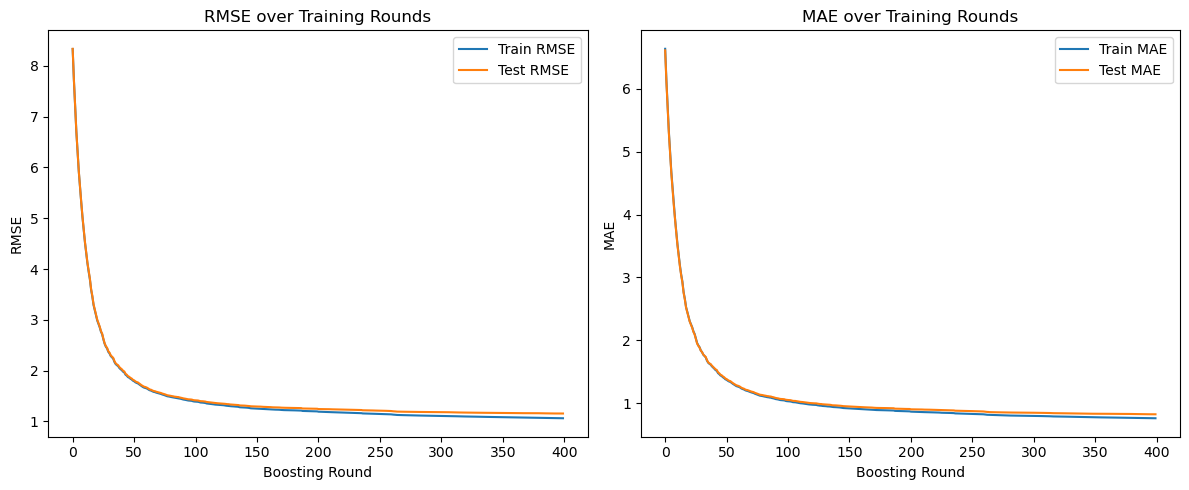

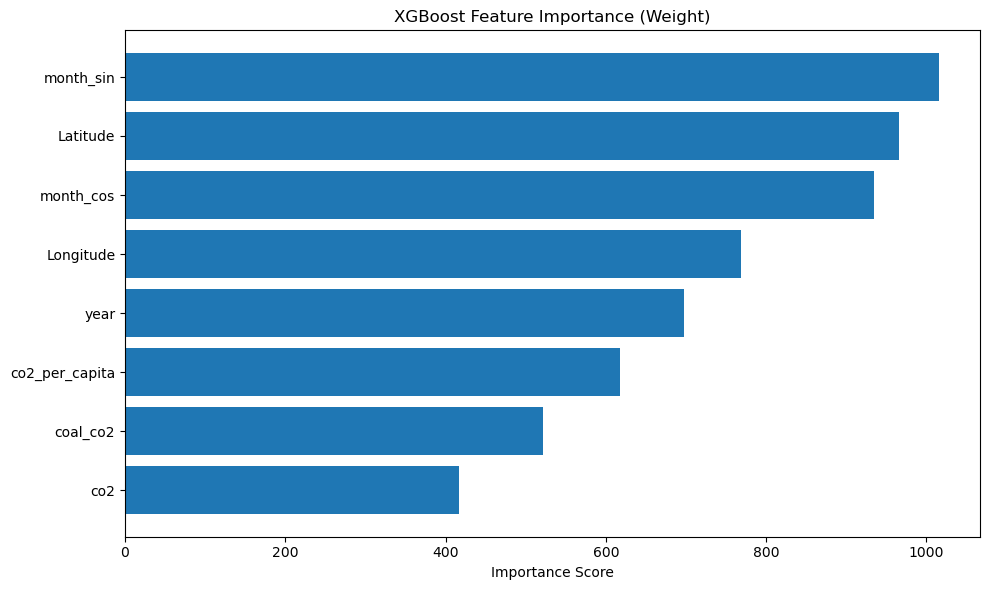

In [35]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np


X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)


model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=400,
    early_stopping_rounds=20,
    eval_metric=['rmse', 'mae'],
    verbosity=0,
    reg_alpha=0.5,  
    reg_lambda=1.0, 
    gamma=0.1,
    max_depth=4,
    learning_rate=0.1,

)




model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False  
)


y_pred = model.predict(X_test)
results = model.evals_result()

print("\n=== Final Metrics ===")
print(f"R²: {r2_score(y_test, y_pred):.4f}")
print(f"RMSE: {results['validation_1']['rmse'][-1]:.4f}")  
print(f"MAE: {results['validation_1']['mae'][-1]:.4f}")


plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(results['validation_0']['rmse'], label='Train RMSE')
plt.plot(results['validation_1']['rmse'], label='Test RMSE')
plt.legend()
plt.title('RMSE over Training Rounds')
plt.xlabel('Boosting Round')
plt.ylabel('RMSE')


plt.subplot(1, 2, 2)
plt.plot(results['validation_0']['mae'], label='Train MAE')
plt.plot(results['validation_1']['mae'], label='Test MAE')
plt.legend()
plt.title('MAE over Training Rounds')
plt.xlabel('Boosting Round')
plt.ylabel('MAE')

plt.tight_layout()
plt.show()

importance = model.get_booster().get_score(importance_type='weight')

filtered_importance = {
    k: v for k, v in importance.items() 
    if not k.lower().startswith('city_')
}

sorted_idx = np.argsort(list(importance.values()))[-20:]  # Top 20 features

plt.figure(figsize=(10, 6))
plt.barh(
    range(len(sorted_idx)),
    [list(importance.values())[i] for i in sorted_idx],
    align='center'
)
plt.yticks(
    range(len(sorted_idx)),
    [list(importance.keys())[i] for i in sorted_idx]
)
plt.title('XGBoost Feature Importance (Weight)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

In [36]:
# from sklearn.ensemble import RandomForestRegressor

# rf = RandomForestRegressor(n_estimators=100, random_state=42)
# rf.fit(X_train, y_train)

# y_pred = rf.predict(X_test)
# print(f"Random Forest:")
# print(f"  MAE: {mean_absolute_error(y_test, y_pred):.2f}")
# print(f"  R²: {r2_score(y_test, y_pred):.2f}")

# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import RandomizedSearchCV
# import numpy as np

# param_grid_rf = {
#     'n_estimators': [100, 200, 300, 400, 500],
#     'max_depth': [None, 10, 20, 30, 50],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2']
# }


# rf = RandomForestRegressor(random_state=42)

# rf_search = RandomizedSearchCV(
#     estimator=rf,
#     param_distributions=param_grid_rf,
#     n_iter=50,  # Number of random combinations to try
#     cv=5,       # 5-fold cross-validation
#     scoring='neg_mean_squared_error',  # Optimize for RMSE
#     verbose=1,
#     random_state=42,
#     n_jobs=-1   # Use all CPU cores
# )


# rf_search.fit(X_train, y_train)


# print("Best Random Forest Params:", rf_search.best_params_)

In [37]:
# print("Best Random Forest parameters:", rf_search.best_params_)
# print("Best score (negative MSE):", rf_search.best_score_)

In [38]:
# import pandas as pd
# import numpy as np
# from xgboost import XGBRegressor


# X_train = X_train.astype(np.float32)  
# y_train = y_train.astype(np.float32)


# model = XGBRegressor(
#     objective='reg:squarederror',
#     n_estimators=1000,
#     early_stopping_rounds=50,
#     eval_metric='rmse'
# )


# model.fit(
#     X_train.values, 
#     y_train.values,
#     eval_set=[(X_test.values, y_test.values)],
#     verbose=10
# )


# y_pred = model.predict(X_test.values)
# print("MAE:", mean_absolute_error(y_test, y_pred))


Epoch 1/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 121.4137 - mae: 8.4189 - mse: 119.2358 - val_loss: 34.3535 - val_mae: 4.8916 - val_mse: 32.1483 - learning_rate: 0.0010
Epoch 2/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 33.5032 - mae: 4.4357 - mse: 31.3089 - val_loss: 17.8403 - val_mae: 3.2850 - val_mse: 15.6778 - learning_rate: 0.0010
Epoch 3/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 28.3747 - mae: 4.0463 - mse: 26.2178 - val_loss: 13.8270 - val_mae: 2.7050 - val_mse: 11.7008 - learning_rate: 0.0010
Epoch 4/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - loss: 25.5574 - mae: 3.8417 - mse: 23.4421 - val_loss: 16.5735 - val_mae: 3.2455 - val_mse: 14.4952 - learning_rate: 0.0010
Epoch 5/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - loss: 22.4876 - mae: 3.5658 - mse: 20.4153 - val_loss: 11.2893 - val_mae: 2.4709 - val_mse: 9.2457 - learning_rate: 0.0010
Epoch 6/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20.8145 - mae: 3.4430 - mse: 18.7833 - 

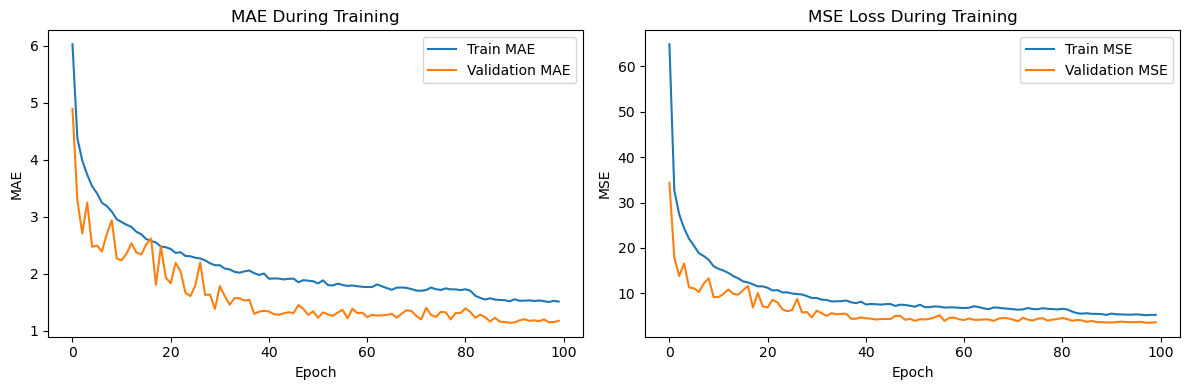

In [40]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.regularizers import l1_l2
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),  
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation='relu', kernel_regularizer=l1_l2(l2=0.01)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)  
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mae', 'mse']  
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-5)
]


early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


y_pred = model.predict(X_test_scaled).flatten()
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nNeural Network Results:")
print(f"- MAE: {mae:.4f}")  
print(f"- RMSE: {rmse:.4f}")
print(f"- R²: {r2:.4f}")
print(f"- Stopped at epoch: {len(history.history['loss'])}")


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE During Training')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Validation MSE')
plt.title('MSE Loss During Training')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

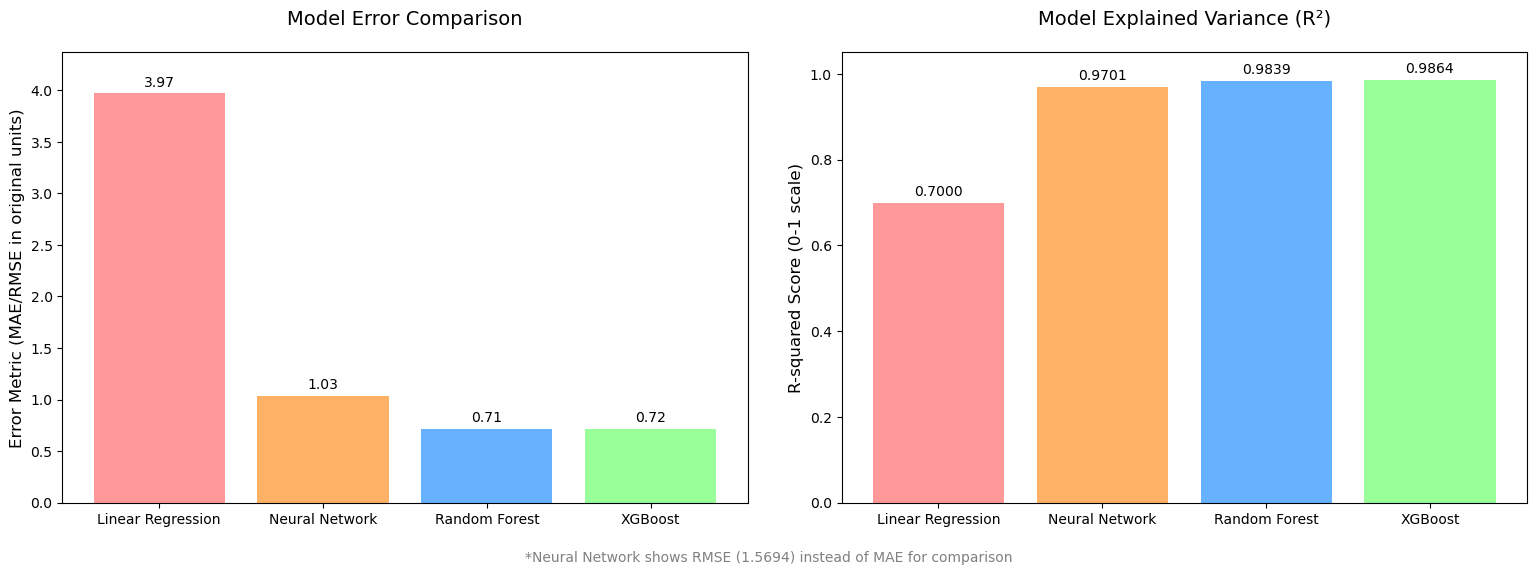

In [41]:
import matplotlib.pyplot as plt
import numpy as np


models = ['Linear Regression', 'Neural Network', 'Random Forest', 'XGBoost']
mae_scores = [5.4900, 0.8246, 0.7856, 0.7469]  
r2_scores = [0.3600, 0.9836, 0.9837, 0.9855]



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))


bars = ax1.bar(models, mae_scores, color=['#FF9999','#FFB266','#66B2FF','#99FF99'])
ax1.set_title('Model Error Comparison', pad=20, fontsize=14)
ax1.set_ylabel('Error Metric (MAE/RMSE in original units)', fontsize=12)
ax1.set_ylim(0, max(mae_scores)*1.1)


for bar in bars:
    height = bar.get_height()
    ax1.annotate(f'{height:.2f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=10)


bars = ax2.bar(models, r2_scores, color=['#FF9999','#FFB266','#66B2FF','#99FF99'])
ax2.set_title('Model Explained Variance (R²)', pad=20, fontsize=14)
ax2.set_ylabel('R-squared Score (0-1 scale)', fontsize=12)
ax2.set_ylim(0, 1.05)


for bar in bars:
    height = bar.get_height()
    ax2.annotate(f'{height:.4f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=10)


plt.figtext(0.5, 0.01, 
            '*Neural Network shows RMSE (1.5694) instead of MAE for comparison', 
            ha='center', fontsize=10, color='gray')
plt.tight_layout(pad=3.0)
plt.show()

# SHAP ANALYSIS MORE IN DEPTH TO HOW AND WHICH FEATURES HAS INFLUENCE 

/var/folders/t0/0st1c18s0z597q_hvy63rvwc0000gn/T/ipykernel_13039/54249622.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
/var/folders/t0/0st1c18s0z597q_hvy63rvwc0000gn/T/ipykernel_13039/54249622.py:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


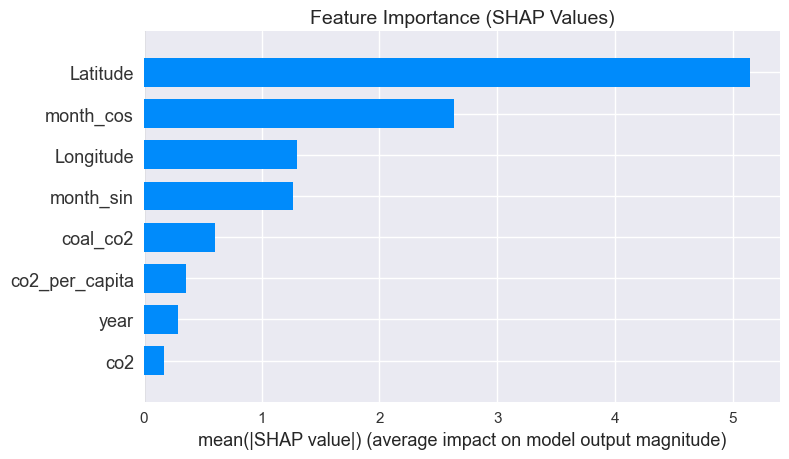

/var/folders/t0/0st1c18s0z597q_hvy63rvwc0000gn/T/ipykernel_13039/54249622.py:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


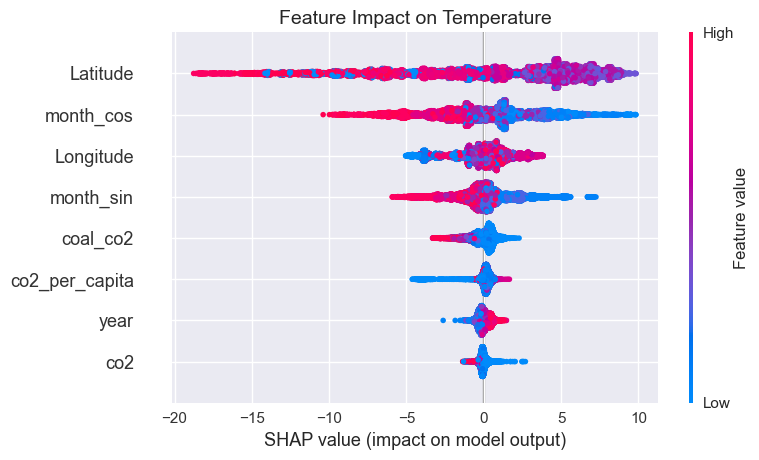

<Figure size 800x400 with 0 Axes>

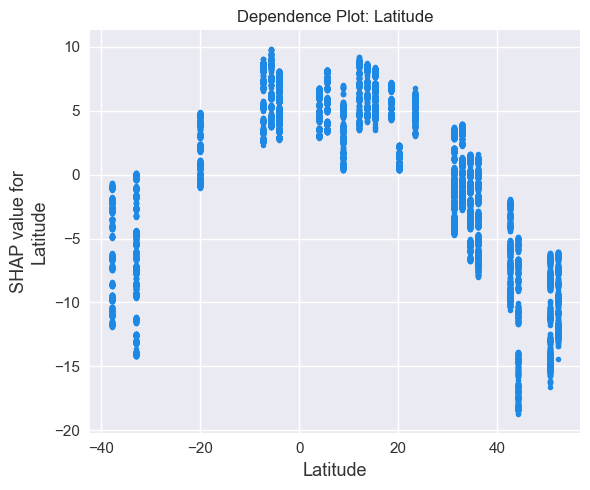

<Figure size 800x400 with 0 Axes>

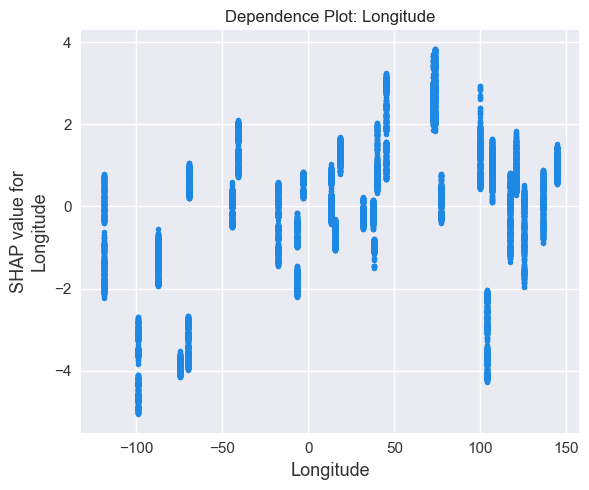

<Figure size 800x400 with 0 Axes>

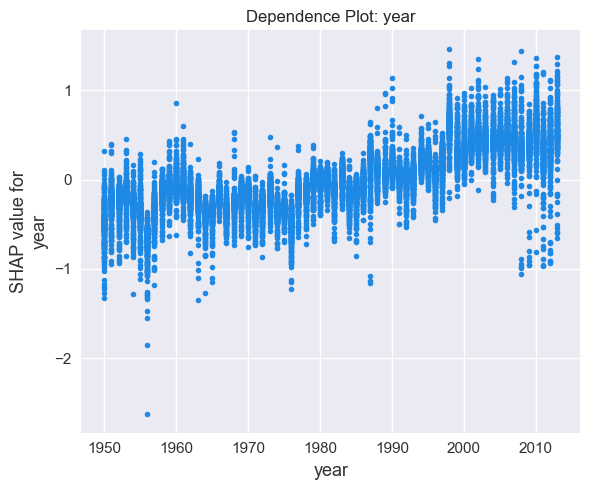

<Figure size 800x400 with 0 Axes>

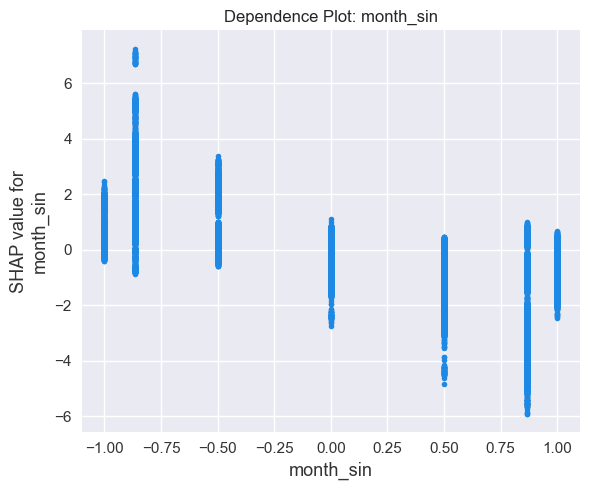

<Figure size 800x400 with 0 Axes>

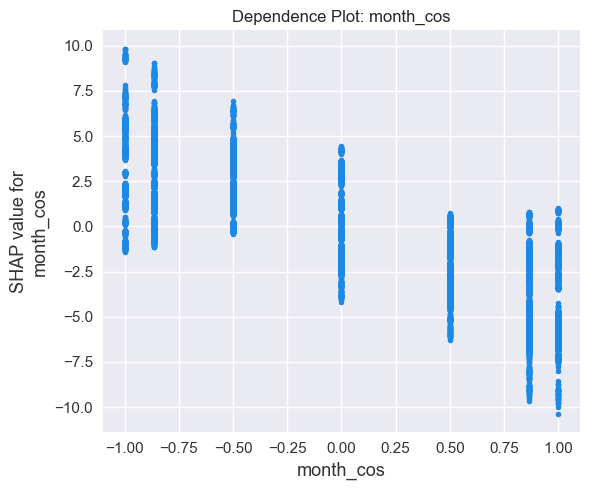

<Figure size 800x400 with 0 Axes>

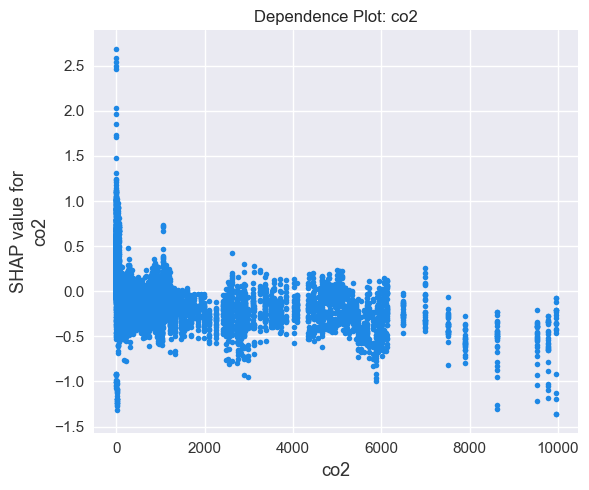

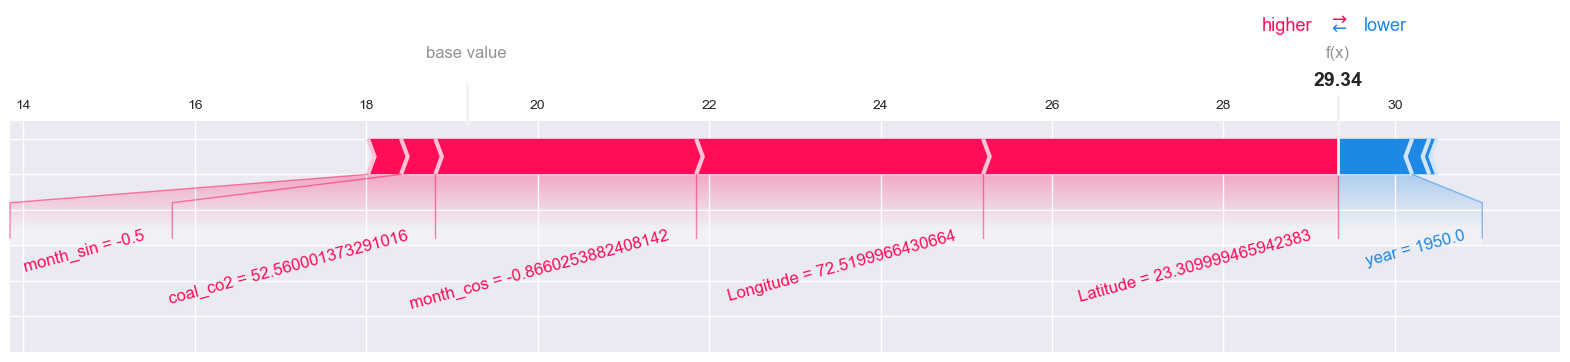

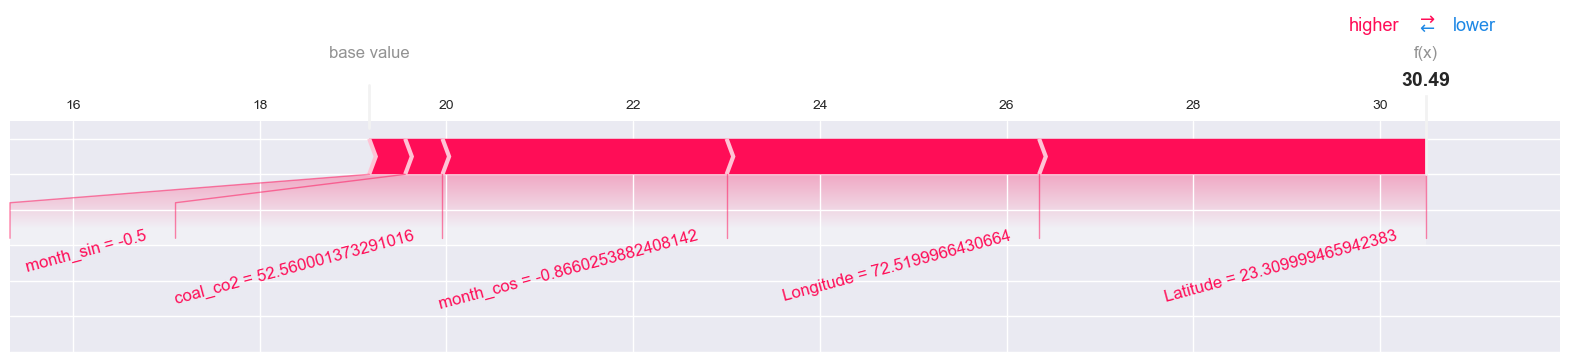

In [42]:
import shap
import matplotlib.pyplot as plt


explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_train)


plt.style.use('seaborn')


plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_train, plot_type="bar", show=False)
plt.title("Feature Importance (SHAP Values)", fontsize=14)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_train, show=False)
plt.title("Feature Impact on Temperature", fontsize=14)
plt.tight_layout()
plt.show()


for feature in X_train.columns[:6]:  
    plt.figure(figsize=(8, 4))
    shap.dependence_plot(
        feature, 
        shap_values.values, 
        X_train, 
        interaction_index=None,
        show=False
    )
    plt.title(f"Dependence Plot: {feature}", fontsize=12)
    plt.tight_layout()
    plt.show()


sample_idx = 0


shap.plots.force(
    base_value=explainer.expected_value,
    shap_values=shap_values[sample_idx].values,
    features=X_train.iloc[sample_idx],
    matplotlib=True,
    text_rotation=15
)


features_to_show = ["Latitude", "month_cos", "coal_co2", "month_sin", "Longitude"]  # Example


feature_indices = [X_train.columns.get_loc(f) for f in features_to_show]


filtered_shap = shap_values[sample_idx].values[feature_indices]
filtered_features = X_train.iloc[sample_idx, feature_indices]


shap.plots.force(
    base_value=explainer.expected_value,
    shap_values=filtered_shap,
    features=filtered_features,
    feature_names=features_to_show, 
    matplotlib=True,
    text_rotation=15
)